In [1]:
import matplotlib

from os import environ
import ast
from TensorflowUtils.DataQuery import DataHandle
from pandas import DataFrame, read_csv, Series

from matplotlib import pyplot as plt


environ["CUDA_VISIBLE_DEVICES"]="2"

models_columns: list = [
                    "model_name",
                    "total_params",
                    "params_distribution",
                    "total_layers",
                    "total_treinable_layers",
                    "total_paths",
                    "total_kernel_regularizers",
                    "total_bias_regularizers",
                    "total_activity_regularizers",
                    "kernel_regularizers_distribution",
                    "bias_regularizers_distribution",
                    "activity_regularizers_distribution",
                    "kernel_regularizers_L1_distribution",
                    "bias_regularizers_L1_distribution",
                    "activity_regularizers_L1_distribution",
                    "kernel_regularizers_L2_distribution",
                    "bias_regularizers_L2_distribution",
                    "activity_regularizers_L2_distribution",
                    "initializer_count",
                    "dropout_count",
                    "dropout_distribution",
                    "batch_normalization_count",
                    "batch_normalization_distribution"
                 ]

training_columns: list = [
                    "training_idx",
                    "model_name",
                    "optimizer_args",
                    "loss_args",
                    "data_set_info",
                    "best_results",
                    "date_time",
                    "training_time_seconds"
                    "training_time",
                    "n_epochs"
                 ]

def literal_converter (element) -> any:
    try: 
        new_element = ast.literal_eval(element)
    except SyntaxError: # probably str
        new_element = str(element)
        
    return new_element
        
            


In [2]:
training_data = read_csv("./Logs/Trainings_data.csv", converters= dict.fromkeys(training_columns, literal_converter))
models_data = read_csv("./Logs/Models_data.csv", converters= dict.fromkeys(models_columns, literal_converter))

In [3]:
x = []
y1 = []
y2 = []
y3 = []
y1_val = []
y2_val = []
y3_val = []
for idx, data in training_data.iterrows():

    x.append(int(models_data.loc[models_data['model_name'] == data["model_name"]]["total_params"]))
    y1.append(data["best_results"]["val_three_ssim"])
    y2.append(data["best_results"]["val_psnrb"])
    y3.append(data["best_results"]["val_ssim_metric"])

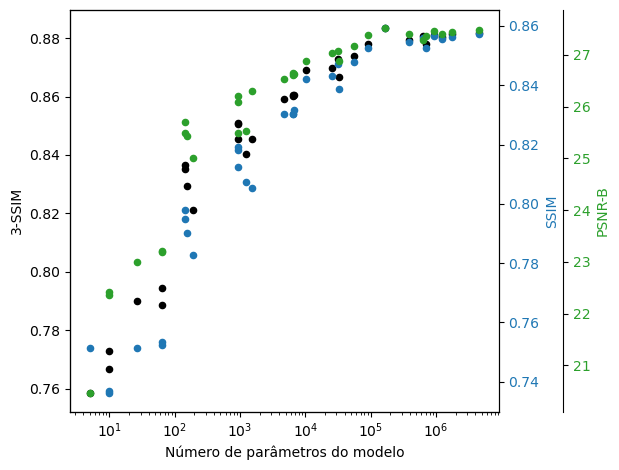

In [4]:
fig, ax1 = plt.subplots()

ax1.set_xscale("log")
ax1.set_xlabel('Número de parâmetros do modelo')

ax1.set_ylabel('3-SSIM', color="black")
ax1.scatter(x, y1, color="black", s = 20)
ax1.tick_params(axis='y', labelcolor="black")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('SSIM', color=color)  # we already handled the x-label with ax1
ax2.scatter(x, y3, color=color, s = 20)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()

color = 'tab:green'
ax3.set_ylabel('PSNR-B', color=color)  # we already handled the x-label with ax1
ax3.scatter(x, y2, color=color, s = 20)
ax3.tick_params(axis='y', labelcolor=color)
ax3.spines['right'].set_position((('axes'), 1.15))


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("my_plot.jpg")
plt.show()


# Imagens

In [5]:
from modules.DataMod import DataSet
from tensorflow.keras.models import load_model, Model
from modules.CustomLosses import L3SSIM
from ImageMetrics.metrics import three_ssim, psnrb


dataset = DataSet().load_rafael_cifar_10_noise_data()

model: Model = load_model("/home/apeterson056/AutoEncoder/codigoGitHub/IC-AutoEncoder/Logs/rafael_cifar_10/ResidualAutoEncoder-2.1-64x64/32/model_best_training_checkpoint",
compile=False)

In [6]:
model.compile(metrics=three_ssim)
model.evaluate(dataset.x_test, dataset.y_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
313/313 [==============================] - 61s 104ms/step - loss: 0.0000e+00 - three_ssim: 0.8822


[0.0, 0.882497251033783]

In [24]:
from random import sample
from modules.misc import ssim_metric
from modules.finding_best_sigma import find_best_sigma_for_ssim
from random import seed
from numpy import clip, array, append, around
from scipy.ndimage import gaussian_filter

seed(12345)

sample_imgs = sample(range(0,dataset.x_test.shape[0]), 4)

results = clip(model.predict(dataset.x_test[sample_imgs]), 0, 255)[2:].astype('float64')
input_imgs = clip(dataset.x_test[sample_imgs], 0, 255)[2:].astype('float64')
target_imgs = clip(dataset.y_test[sample_imgs], 0, 255)[2:].astype('float64')

best_sigma = find_best_sigma_for_ssim(x =dataset.x_test[sample_imgs], y = dataset.y_test[sample_imgs])
print(best_sigma)
gaussian_imgs = clip(gaussian_filter(dataset.x_test[sample_imgs], (0,best_sigma,best_sigma,0)), 0, 255)[2:].astype('float64')

three_ssim_result = three_ssim(target_imgs, results)
ssim_metric_result = ssim_metric(target_imgs, results)
psnrb_result = psnrb(target_imgs, results)

three_ssim_input = three_ssim(target_imgs, input_imgs)
ssim_metric_input = ssim_metric(target_imgs, input_imgs)
psnrb_input = psnrb(target_imgs, input_imgs)

three_ssim_filter = three_ssim(target_imgs, gaussian_imgs)
ssim_metric_filter = ssim_metric(target_imgs, gaussian_imgs)
psnrb_filter = psnrb(target_imgs, gaussian_imgs)


0.2
1.1951171875000002


In [25]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize = (6,3), subplot_kw={'xticks': [], 'yticks': []})
n_lines = 2
n_columns = 4

for i in range(0, n_lines):
    
    # Alvo
    axs.flat[n_columns*i].imshow(target_imgs[i], cmap='gray', vmin=0, vmax=255)
    if i == 0:
        axs.flat[n_columns*i].set_title("Original")

    # Entrada
    axs.flat[n_columns*i + 1].imshow(input_imgs[i], cmap='gray', vmin=0, vmax=255)
    if i == 0:
        axs.flat[n_columns*i + 1].set_title("Entrada")
    axs.flat[n_columns*i + 1].annotate(f"({three_ssim_input[i].numpy():.2f}, {ssim_metric_input[i].numpy():.2f}, {psnrb_input[i].numpy():.0f})", (-0.05,-0.15), xycoords = 'axes fraction')

    # Rede
    axs.flat[n_columns*i + 2].imshow(results[i], cmap='gray', vmin=0, vmax=255)
    if i == 0:
        axs.flat[n_columns*i + 2].set_title("Rede")
    axs.flat[n_columns*i + 2].annotate(f"({three_ssim_result[i].numpy():.2f}, {ssim_metric_result[i].numpy():.2f}, {psnrb_result[i].numpy():.0f})", (-0.05,-0.15), xycoords = 'axes fraction')

    # Filtro gaussiano
    axs.flat[n_columns*i + 3].imshow(gaussian_imgs[i], cmap='gray', vmin=0, vmax=255)
    if i == 0:
        axs.flat[n_columns*i + 3].set_title("Filtro")
    axs.flat[n_columns*i + 3].annotate(f"({three_ssim_filter[i].numpy():.2f}, {ssim_metric_filter[i].numpy():.2f}, {psnrb_filter[i].numpy():.0f})", (-0.05,-0.15), xycoords = 'axes fraction')

plt.savefig("test.png", bbox_inches = "tight")

In [9]:
from scipy.stats import pearsonr
from numpy import log
print(pearsonr(log(x), y1))
print(pearsonr(log(x), y2))
print(pearsonr(log(x), y3))

(0.9151275678592269, 9.09291519186007e-14)
(0.881711601318401, 1.230019813267214e-11)
(0.9372339650138302, 9.889176137687214e-16)
